In [1]:
!pip install gymnasium stable-baselines3 colorama --quiet

In [78]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
from typing import Optional, Tuple
import colorama
from colorama import Fore
from colorama import Style
from stable_baselines3 import A2C, PPO
import numpy as np
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
import time
import matplotlib.pyplot as plt

seed = 42
np.random.seed(seed)

colorama.init(autoreset=True)

# global game variables
GAME_LENGTH = 6
WORD_LENGTH = 5


def encodeToStr(encoding):
    string = ""
    for enc in encoding:
        string += chr(ord('a') + enc)
    return string

def strToEncode(lines):
    encoding = []
    for line in lines:
        assert len(line.strip()) == 5
        encoding.append([ord(char) - 97 for char in line.strip()])
    return encoding

with open("gym_wordle/envs/5_words.txt", "r") as f:
    WORDS = strToEncode(f.readlines())

class InvalidWordException(Exception):
  pass

class WordleEnv(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self):
        super(WordleEnv, self).__init__()
        self.action_space = spaces.MultiDiscrete([26] * WORD_LENGTH)
        self.observation_space = spaces.Dict({
            'board': spaces.Box(low=-1, high=2, shape=(GAME_LENGTH, WORD_LENGTH), dtype=int),
            'alphabet': spaces.Box(low=-1, high=2, shape=(26,), dtype=int)
        })
        self.valid_words = WORDS
        self.correct_positions = [None] * WORD_LENGTH
        self.wrong_positions = [set() for _ in range(WORD_LENGTH)]
        self.incorrect_letters = set()
        self.guesses = []

    def step(self, action) -> Tuple[dict, float, bool, bool, dict]:
        if not tuple(action) in self.valid_words:
            action = self.generate_valid_action()

        board_row_idx = GAME_LENGTH - self.guesses_left
        for idx, char in enumerate(action):
            if self.hidden_word[idx] == char:
                encoding = 2
            elif char in self.hidden_word:
                encoding = 1
            else:
                encoding = 0

            self.board[board_row_idx, idx] = encoding
            self.alphabet[char] = encoding

        self.guesses_left -= 1
        self.guesses.append(action)

        if all(self.board[board_row_idx, :] == 2):
            reward = 1.0
            done = True
        else:
            if self.guesses_left > 0:
                reward = 0.0
                done = False
            else:
                reward = -1.0
                done = True

        truncated = False
        self.update_constraints(action)
        return self._get_obs(), reward, done, truncated, {}
    
    def rand_step(self, action):
        if not tuple(action) in self.valid_words:
            action = self.generate_valid_action()

        # update game board and alphabet tracking
        board_row_idx = GAME_LENGTH - self.guesses_left
        for idx, char in enumerate(action):

            if self.hidden_word[idx] == char:
                encoding = 2
            elif char in self.hidden_word:
                encoding = 1
            else:
                encoding = 0

            self.board[board_row_idx, idx] = encoding
            self.alphabet[char] = encoding

        # update guesses remaining tracker
        self.guesses_left -= 1

        # update previous guesses made
        self.guesses.append(action)

        # check to see if game is over
        if all(self.board[board_row_idx, :] == 2):
            reward = 1.0
            done = True
        else:
            if self.guesses_left > 0:
                reward = 0.0
                done = False
            else:
                reward = -1.0
                done = True
        truncated = False
        return self._get_obs(), reward, done, truncated, {}

    def generate_valid_action(self):
        for word in self.valid_words:
            if self.is_valid_guess(word):
                return word
        return random.choice(self.valid_words)

    def is_valid_guess(self, word):
        for i, char in enumerate(word):
            if self.correct_positions[i] is not None and self.correct_positions[i] != char:
                return False
            if char in self.incorrect_letters:
                return False
            if char in self.wrong_positions[i]:
                return False
        return True

    def update_constraints(self, action):
        board_row_idx = GAME_LENGTH - self.guesses_left - 1
        for i, char in enumerate(action):
            if self.board[board_row_idx, i] == 2:
                self.correct_positions[i] = char
            elif self.board[board_row_idx, i] == 1:
                self.wrong_positions[i].add(char)
            elif self.board[board_row_idx, i] == 0:
                self.incorrect_letters.add(char)

    def _get_obs(self) -> dict:
        return {'board': self.board, 'alphabet': self.alphabet}

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None) -> Tuple[dict, dict]:
        super().reset(seed=seed)
        self.hidden_word = random.choice(self.valid_words)
        self.guesses_left = GAME_LENGTH
        self.board = np.negative(np.ones(shape=(GAME_LENGTH, WORD_LENGTH), dtype=int))
        self.alphabet = np.negative(np.ones(shape=(26,), dtype=int))
        self.correct_positions = [None] * WORD_LENGTH
        self.wrong_positions = [set() for _ in range(WORD_LENGTH)]
        self.incorrect_letters = set()
        self.guesses = []
        return self._get_obs(), {}

    def render(self, mode="human"):
        assert mode in ["human"], "Invalid mode, must be \"human\""
        print('###################################################')
        for i in range(len(self.guesses)):
            for j in range(WORD_LENGTH):
                letter = chr(ord('a') + self.guesses[i][j])
                if self.board[i][j] == 0:
                    print(Fore.BLACK + Style.BRIGHT + letter + " ", end='')
                elif self.board[i][j] == 1:
                    print(Fore.YELLOW + Style.BRIGHT + letter + " ", end='')
                elif self.board[i][j] == 2:
                    print(Fore.GREEN + Style.BRIGHT + letter + " ", end='')
            print()
        print()

        for i in range(len(self.alphabet)):
            letter = chr(ord('a') + i)
            if self.alphabet[i] == 0:
                print(Fore.BLACK + Style.BRIGHT + letter + " ", end='')
            elif self.alphabet[i] == 1:
                print(Fore.YELLOW + Style.BRIGHT + letter + " ", end='')
            elif self.alphabet[i] == 2:
                print(Fore.GREEN + Style.BRIGHT + letter + " ", end='')
            elif self.alphabet[i] == -1:
                print(letter + " ", end='')
        print()
        print('###################################################')
        print()


In [3]:
env = Monitor(WordleEnv())

models = {"A2C": A2C, "PPO": PPO}

n_steps = 100000
eval_freq = 1000

def train(models, n_steps, eval_freq):
    results = {}
    for alg_name, alg in models.items():
        model = alg("MultiInputPolicy", env, verbose=1)
        start_time = time.time()
        rewards = []
        for step in range(0, n_steps, eval_freq):
            model.learn(total_timesteps=eval_freq, reset_num_timesteps=False)
            mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=30)
            rewards.append(mean_reward)
            training_time = time.time() - start_time
            results[alg_name] = np.mean(rewards), np.var(rewards), rewards, training_time
            model.save(f"{alg_name}_wordle")
    return results

A2C_PPO = train(models, n_steps, eval_freq)

def extract_mean_std(results):
    extracted_data = {}
    for key, value in results.items():
        mean_reward, std_reward, _, training_time= value
        extracted_data[key] = (mean_reward, std_reward**2, training_time)
    return extracted_data

A2C_PPO_mean_std = extract_mean_std(A2C_PPO)
print(A2C_PPO_mean_std)

2024-06-10 19:04:59.161555: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using cuda device
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 5.52     |
|    ep_rew_mean        | 0.0444   |
| time/                 |          |
|    fps                | 158      |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -16      |
|    explained_variance | 0.241    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 1.51     |
|    value_loss         | 0.262    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 5.34     |
|    ep_rew_mean        | 0.28     |
| time/                 |          |
|    fps                | 176      |
|    iterations         | 200      |
|    time_elapsed       | 5        |
|    total_timesteps  

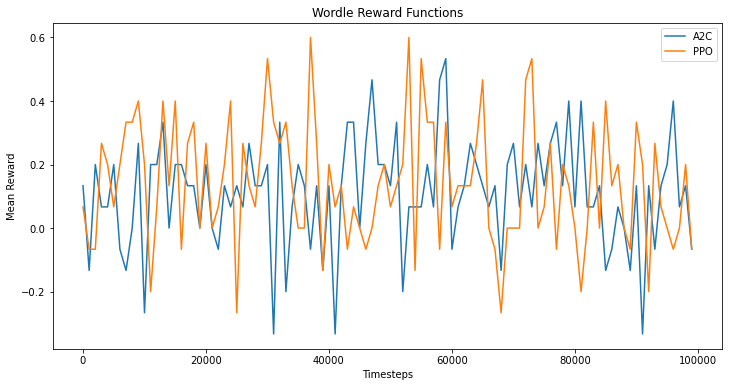

<Figure size 432x288 with 0 Axes>

In [4]:
def plot_rewards(results, title):
    plt.figure(figsize=(12, 6))
    for key, value in results.items():
        alg_name = key
        _, _, rewards, _ = value
        plt.plot(range(0, n_steps, eval_freq), rewards, label=f"{alg_name}")
    plt.xlabel('Timesteps')
    plt.ylabel('Mean Reward')
    plt.title(title)
    plt.legend()
    plt.show()
    plt.savefig(f"{alg_name}.png")

plot_rewards(A2C_PPO, "Wordle Reward Functions")

In [94]:
env = Monitor(WordleEnv())

A2C_model = A2C.load("A2C_wordle")
PPO_model = PPO.load("PPO_wordle")
models = {'A2C': A2C_model, 'PPO': PPO_model}

def simulate_game(model):
    obs, info = env.reset()
    done = False
    rewards = []
    num_iter = 0
    while not done:
        action, _states = model.predict(obs, deterministic=True)

        action = env.generate_valid_action()

        obs, reward, done, truncated, info = env.step(action)
        rewards.append(reward)
        num_iter += 1
        env.render()

def run_games(model, num_games=100):
    env = WordleEnv()
    successes = 0
    guesses = 0
    successful_guesses = 0
    for _ in range(num_games):
        obs, info = env.reset()
        done = False
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)

        if reward > 0: 
            successes += 1
            successful_guesses += len(env.guesses)
        guesses += len(env.guesses)

    success_ratio = successes / num_games
    avg_guesses = guesses / num_games
    avg_successful_guesses = successful_guesses / successes
    return success_ratio, avg_guesses, avg_successful_guesses

for alg_name, alg in models.items():
    num_games = 100000
    success_ratio, avg_guesses, avg_successful_guesses = run_games(alg, num_games)

    print(f"Success ratio over {num_games} games using {alg_name}: {success_ratio} with {avg_guesses} guesses on average.", "\n",
          f"Average guesses on successful games are: {avg_successful_guesses}")

Success ratio over 100000 games using A2C: 0.57463 with 5.51068 guesses on average. 
 Average guesses on successful games are: 5.148460748655657
Success ratio over 100000 games using PPO: 0.57208 with 5.51049 guesses on average. 
 Average guesses on successful games are: 5.144332960425116


In [93]:
def run_random(num_games=100):
    env = WordleEnv()
    successes = 0
    guesses = 0
    successful_guesses = 0
    for _ in range(num_games):
        obs, info = env.reset()
        done = False
        while not done:
            action = random.choice(env.valid_words)
            obs, reward, done, truncated, info = env.rand_step(action)

        if reward > 0: 
            successes += 1
            successful_guesses += len(env.guesses)
        guesses += len(env.guesses)

    success_ratio = successes / num_games
    avg_guesses = guesses / num_games
    avg_successful_guesses = successful_guesses / successes
    return success_ratio, avg_guesses, avg_successful_guesses

num_games = 100000
success_ratio, avg_guesses, avg_successful_guesses = run_random(num_games)

print(f"Success ratio over {num_games} games using random guesses: {success_ratio} with {avg_guesses} guesses on average.", "\n",
      f"Average guesses on successful games are: {avg_successful_guesses}")

Success ratio over 100000 games using random guesses: 4e-05 with 5.9998 guesses on average. 
 Average guesses on successful games are: 1.0
